## Full working example with all of our relevant and important code

In [1]:
# Packages
import h5py
import time
import numpy as np
from amuse.lab import Particles
from amuse.couple import bridge
import matplotlib.pyplot as plt
from amuse.units.constants import G
from amuse.units import units, constants
from amuse.lab import Huayno, nbody_system
from amuse.community.ph4.interface import ph4
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.ext.orbital_elements import new_binary_from_orbital_elements

In [2]:
def make_moon_system(moons, eccentricities, inclinations, kozai=True, *args):

    ''' Function to create a particle system of the Galileann moon(s) with Jupiter and the Sun.
        
    @Input: 
        list of Galileann Moon names in string format (any combination of: io, europa, ganymede, 
        callisto), list of eccentricities, list of inclinations (dimensionless), boolean 
        response to kozai (sets whether or not to include the sun, default: kozai=True).
               
    @Returns: 
        Particle system of the given moon(s) with Jupiter - and the Sun if kozai=True.
        
    @Example: 
        system = make_moon_system(moons=['io', 'europa'], eccentricities=[0.4, 0.6], 
        inclinations=[50, 60], kozai=False) '''
  

    # Assigning our variables
    x = zip(eccentricities, inclinations)
    y = list(x)
    z = {}
    for i in range(len(moons)):
        z[moons[i]] = y[i]   
    
    
    # Initialising Sun and Jupiter
    Msun = 1.0|units.MSun
    Mjup = 1.0|units.MJupiter
    rSun = 696340|units.km
    rJup = 69911|units.km
    a_jup = 5.2|units.au
    e_jup = 0.0
    
    system = new_binary_from_orbital_elements(Msun, Mjup, a_jup, e_jup, G=constants.G)
    system[0].name = 'sun'
    system[1].name = 'jupiter'
    jupiter = system[system.name=='jupiter']
    jupiter.semimajor_axis = a_jup
    jupiter.radius = rJup
    sun = system[system.name=='sun']
    sun.radius = rSun
    
    if kozai != True:
        system.remove_particle(system[0]) # removing the Sun (to look at tidal effects only)
        system.move_to_center()
    
    
    # Function to automate addition of particles
    def add_particle(particle, a, e, inc, m, r):
        
        binary = new_binary_from_orbital_elements(jupiter.mass, m, a, eccentricity=e, 
            inclination=inc, G=constants.G)
         
        system.add_particle(binary[1].as_set()) 
        system[-1].name = particle
        moon = system[system.name==particle] 
        
        moon.semimajor_axis = a
        moon.eccentricity = e
        moon.inclination = inc
        moon.radius = r
        moon.position = binary[1].position + jupiter.position
        moon.velocity = binary[1].velocity + jupiter.velocity
        
        system.move_to_center()
    
    
    # Add moons based on input
    if 'io' in moons:
        a = 421800|units.km
        e = z['io'][0]
        inc = z['io'][1]|units.deg
        m = 8.93E22|units.kg
        r = 1821.6|units.km
        add_particle('io', a, e, inc, m, r) 
    
    if 'europa' in moons:
        a = 671100|units.km
        e = z['europa'][0]
        inc = z['europa'][1]|units.deg
        m = 4.80E22|units.kg
        r = 1560.8|units.km
        add_particle('europa', a, e, inc, m, r)  

    if 'ganymede' in moons:
        a = 1070400|units.km
        e = z['ganymede'][0]
        inc = z['ganymede'][1]|units.deg
        m = 1.48E23|units.kg
        r = 2634.1|units.km
        add_particle('ganymede', a, e, inc, m, r)   
        
    if 'callisto' in moons:
        a = 1882700|units.km
        e = z['callisto'][0]
        inc = z['callisto'][1]|units.deg
        m = 1.08E23|units.kg
        r = 2410.3|units.km
        add_particle('callisto', a, e, inc, m, r)  
        
        
    print('Particle system created for: '+ str(system.name))
    return system

In [3]:
class TidalForce():

    ''' Class to update the gravitational accelerations due to tidal friction between Jupiter and
        a given moon. Tidal interactions between moons are ignored. 

        This tidal code gives the bridge system instantaneous kicks (based on position). The 
        equations are based on the Mignard weak-friction tidal model.

        Inspiration was taken from the paper, 'Tidal decay and orbit circularization in close-in
        two-planet systems' (https://doi.org/10.1111/j.1365-2966.2011.18861.x). 

        The kdt parameter absorbs the Love number --> k is the love number and dt is the constant 
        time lag. This has been obtained from the literature to be ~0.02 for the Jupiter - 
        Galilean system (https://doi.org/10.1051/0004-6361/201014337). '''


    def __init__(self, kdt=2e-2):
        self.kdt = kdt
        
    
    # Add our system of particles
    def add_particles(self, particle_set):
        self.particles = particle_set
    
    
    # Bridges to gravity code
    def get_gravity_at_point(self, eps, x, y, z):
        return self.tidal_acceleration(kdt=self.kdt) 
    

    def tidal_acceleration(self, kdt):

        ''' Note: the number of satellites (sun and moons) is needed to reshape the arrays such 
            that they can all be contracted in the correct way (eg. multiplication of vector arrays, 
            with arrays). '''

        num_sat = len(self.particles)-1
        mask = self.particles.name != 'jupiter' # exclude the force of Jupiter on itself
        
        # Initializing required constants
        M = (1|units.MJupiter).value_in(units.kg)
        G = constants.G.value_in( (units.m)**3 / (units.kg * units.s**2) )
        c = constants.c.value_in(units.m/units.s)
        
        # Satellite attributes (including sun for the stellar tides)
        m = (self.particles.mass.value_in(units.kg)[mask]).reshape((num_sat,1))
        R_sat = (self.particles.radius.value_in(units.m)[mask]).reshape((num_sat,1))
        
        # Relative positions
        r_vec = self.particles[mask].position.value_in(units.m) - \
                self.particles[~mask].position.value_in(units.m)

        # Distance between satellite and jupiter
        r = np.linalg.norm(r_vec, axis=1).reshape(num_sat,1)

        # Relative velocities 
        v_vec = self.particles[mask].velocity.value_in(units.m/units.s) - \
                self.particles[~mask].velocity.value_in(units.m/units.s)

        # Velocity (v**2 needed in f_rel)
        v = np.linalg.norm(v_vec, axis=1).reshape(num_sat,1)
        
        # Rotation angular velocity
        omega = np.cross(r_vec, v_vec) / r**2
        
        # Tidal force equation
        f = (-3 * kdt * G * M**2 * R_sat**5 / r**10) * (2 * r_vec * \
            np.sum(r_vec*v_vec, axis=1).reshape((num_sat,1)) + \
            (r**2) * (np.cross(r_vec, omega) + v_vec))
        
        # General relativity contribution
        f_rel = (G * m * M / (c**2 * r**3)) * ( ((4*G*M/r) - v**2)*r_vec + \
            4*(np.sum(r_vec*v_vec, axis=1).reshape(num_sat,1))*v_vec)

        #  The acceleration due to tidal effects (this will be added to the gravitational accel.)
        a = (M + m)*(f + f_rel) / (M * m) 

        ax = np.zeros(num_sat+1)
        ay = np.zeros(num_sat+1)
        az = np.zeros(num_sat+1)
        
        ax[mask] = a[:,0]
        ay[mask] = a[:,1]
        az[mask] = a[:,2]
        
        ax = ax | units.m/(units.s**2)
        ay = ay | units.m/(units.s**2)
        az = az | units.m/(units.s**2)
        
        return ax, ay, az

In [4]:
def integrate_system(moons, eccentricities, inclinations, dt, end_time, kdt=2e-2, kozai=True):

    ''' Function to integrate our system over time for both gravity and tidal evolutions.

    @Input: 
        list of Galileann Moon names in string format (expected in the order: io, europa, ganymede,
        callisto), eccentricities, inclinations, kdt, integration time step, end time, boolean 
        response to kozai (sets whether or not to include the sun, default: kozai=True).

    @Returns: 
        list of evolved eccentrities, inclinations, semimajor-axis values, and the time range at 
        time step intervals.

    @Example: 
        ecc, inc, sma, time_range = integrate_system(moons=['io', 'callsito'], 
        eccentricities=[0.3, 0.6], inclinations=[50, 110], 10, 1000, kozai=False) '''
        
    
    # Checking how long code takes to run
    start_time = time.time()
    
    # Getting system
    system = make_moon_system(moons, eccentricities, inclinations, kozai=kozai)
    
    # Converting Nbody
    converter = nbody_system.nbody_to_si(system.mass.sum(), 
        system[(system.name=='jupiter')].position.length())
    
    # Gravity code
    gravity = Huayno(converter)
    gravity.particles.add_particles(system)
    
    # Eccentricities
    e_io = []
    e_eu = []
    e_ga = []
    e_ca = []
    
    # Inclinations
    i_io = [] | units.deg
    i_eu = [] | units.deg
    i_ga = [] | units.deg
    i_ca = [] | units.deg
    
    #Semimajor axes 
    a_io = [] | units.m
    a_eu = [] | units.m
    a_ga = [] | units.m
    a_ca = [] | units.m

    # Tidal force
    tides = TidalForce(kdt=kdt)
    tides.add_particles(system)
    
    # Bridge for tidal effects
    our_bridge = bridge.Bridge(use_threading=False)    
    our_bridge.add_system(gravity, (tides,))
    our_bridge.timestep = dt|units.yr  

    # Channels
    channel_grav = gravity.particles.new_channel_to(system)
    channel_tf = tides.particles.new_channel_to(system)
    
    # Running gravity code
    time_range = np.arange(0, end_time, dt) | units.yr
    
    print('Integrating system over {} years'.format(end_time))
    print('System evolves every {} years'.format(dt))
    for i,t in enumerate(time_range):
        #print("Time=", t.in_(units.yr))
        
        if 'io' in moons:
            orbit_io = get_orbital_elements_from_binary(
                system[(system.name=='jupiter')|(system.name=='io')], G=constants.G)
            
        if 'europa' in moons:
            orbit_eu = get_orbital_elements_from_binary(
                system[(system.name=='jupiter')|(system.name=='europa')], G=constants.G)
            
        if 'ganymede' in moons:
            orbit_ga = get_orbital_elements_from_binary(
                system[(system.name=='jupiter')|(system.name=='ganymede')], G=constants.G)
            
        if 'callisto' in moons:
            orbit_ca = get_orbital_elements_from_binary(
                system[(system.name=='jupiter')|(system.name=='callisto')], G=constants.G)
        
        our_bridge.evolve_model(t, timestep=dt|units.yr)
        channel_grav.copy()
        channel_tf.copy()
        

        if 'io' in moons:
            a_io.append(orbit_io[2])
            e_io.append(orbit_io[3])
            i_io.append(orbit_io[5])
            
        
        if 'europa' in moons:
            a_eu.append(orbit_eu[2])
            e_eu.append(orbit_eu[3])
            i_eu.append(orbit_eu[5])
            
        
        if 'ganymede' in moons:
            a_ga.append(orbit_ga[2])
            e_ga.append(orbit_ga[3])
            i_ga.append(orbit_ga[5])
            
        
        if 'callisto' in moons:
            a_ca.append(orbit_ca[2])
            e_ca.append(orbit_ca[3])
            i_ca.append(orbit_ca[5])
        
        
    our_bridge.stop()
    
    ecc = []
    inc = [] | units.deg
    sma = [] | units.m
    
    if 'io' in moons:
        ecc.append(e_io)
        inc.append(i_io)
        sma.append(a_io)
        
    if 'europa' in moons:
        ecc.append(e_eu)
        inc.append(i_eu)
        sma.append(a_eu)
        
    if 'ganymede' in moons:
        ecc.append(e_ga)
        inc.append(i_ga)
        sma.append(a_ga)
        
    if 'callisto' in moons:
        ecc.append(e_ca)
        inc.append(i_ca)
        sma.append(a_ca)
        

    print('\nModel fully evolved: Runtime: %s seconds' % (time.time() - start_time))
    
    return ecc, inc, sma, time_range

## Example: Single moon system

In [16]:
# This cell should take ~50 seconds to run

moons = ['io']
eccentricities = [0.3]
inclinations = [70]

dt = 1
end_time = 101
kdt = 360

ecc, inc, sma, time_range = integrate_system(moons, eccentricities, inclinations, dt, end_time, kdt)

Particle system created for: ['sun' 'jupiter' 'io']
Integrating system over 101 years
System evolves every 1 years

Model fully evolved: Runtime: 8.211969137191772 seconds


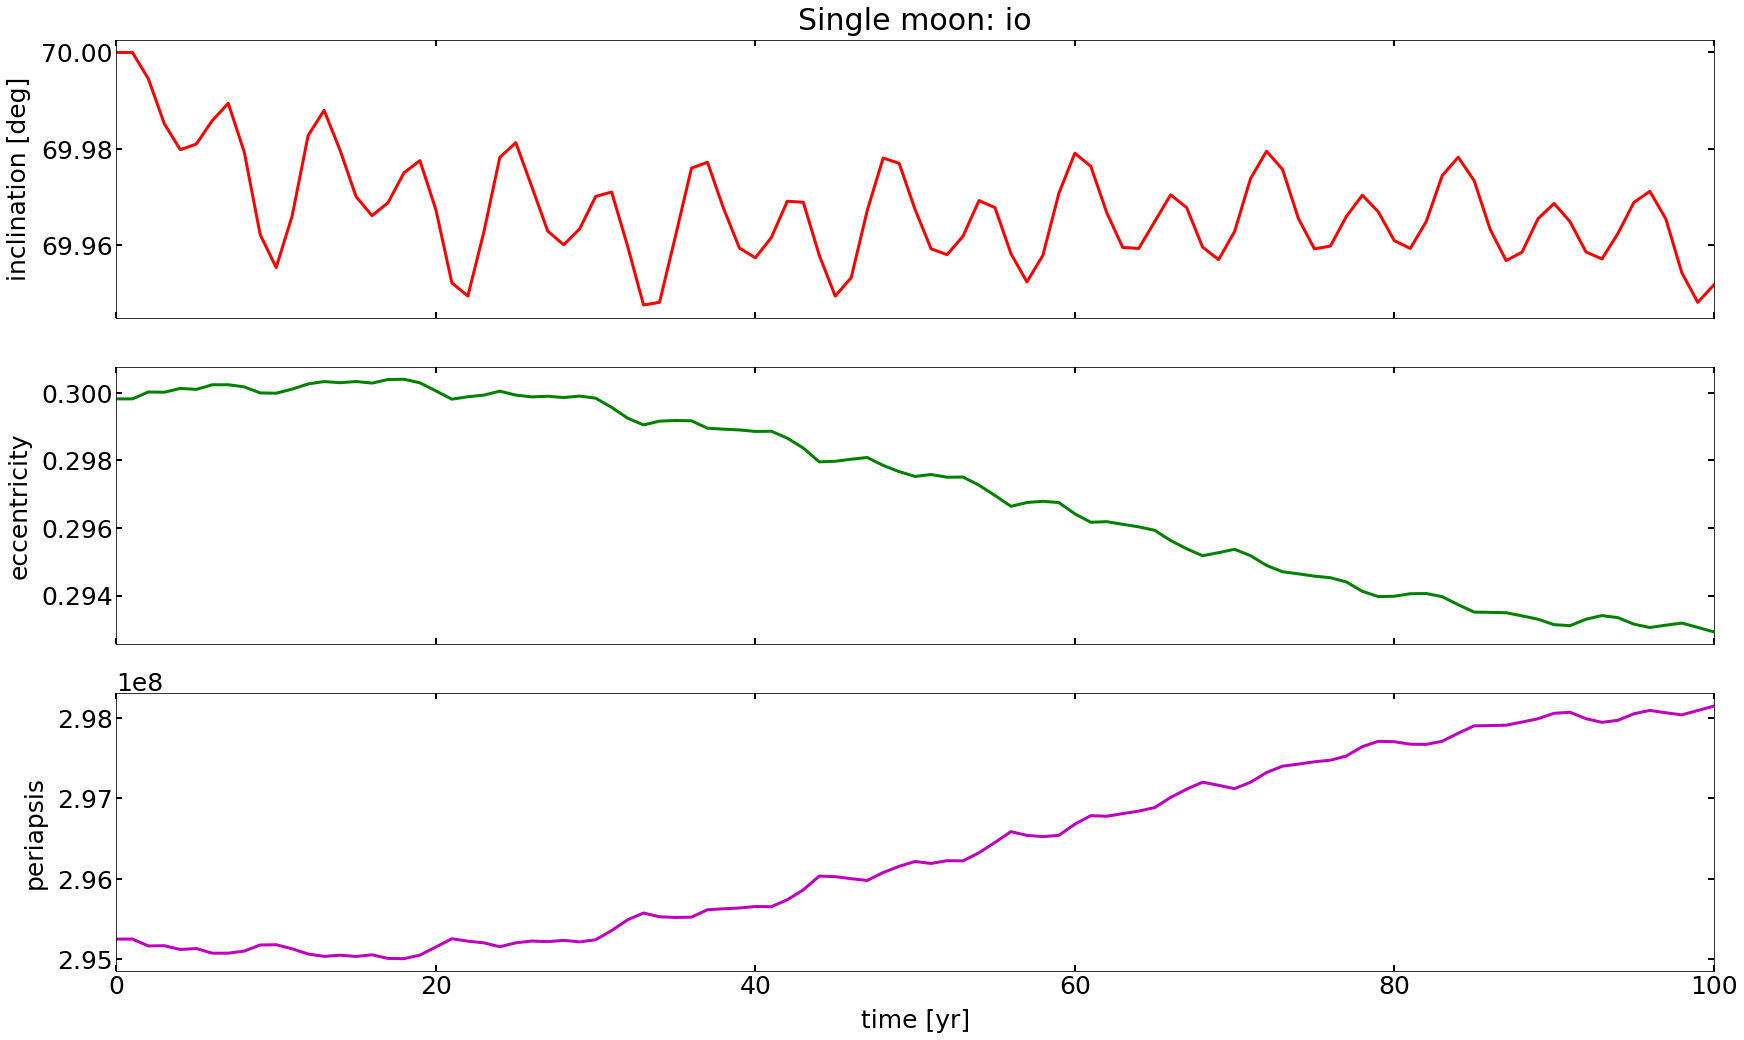

In [18]:
# Plotting evolutionary tracks

def plot_moon(moon, ecc, inc, sma, time_range, savefig=False):

    plt.rcParams.update({'font.size': 25})
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[25, 15], tight_layout=True, sharex=True)
    colours = ['r', 'g', 'm']
    name = moons[0]
    
    t = time_range.value_in(units.yr)
    inc = inc[0].value_in(units.deg)
    ecc = np.array(ecc[0])
    sma = sma[0].value_in(units.m)
    
    ax1.set_title('Single moon: {}'.format(name), pad=10)
    ax3.set_xlabel('time [yr]', labelpad=10)
    
    # Periapsis
    peri = np.array(sma[0]) * (1-np.array(ecc))
    
    ax1.plot(t, inc, color=colours[0], lw=3)  
    ax2.plot(t, ecc, color=colours[1], lw=3)   
    ax3.plot(t, peri, color=colours[2], lw=3)
    
    ax1.set_ylabel('inclination [deg]', labelpad=10)
    ax2.set_ylabel('eccentricity', labelpad=10)
    ax3.set_ylabel('periapsis', labelpad=10)

    ax1.set_xlim([0, 100])
    ax2.set_xlim([0, 100])
    ax3.set_xlim([0, 100])
    
    ax1.tick_params(direction='in', length=6, width=2, top=True, right=True)
    ax2.tick_params(direction='in', length=6, width=2, top=True, right=True)
    ax3.tick_params(direction='in', length=6, width=2, top=True, right=True)
    
    if savefig:
        plt.savefig('{}_all_effects.png'.format(name), dpi=300, facecolor='w', bbox_inches='tight')

    plt.show()
    
    
plot_moon(moons, ecc, inc, sma, time_range)

## Example: Multiple moon system

In [ ]:
# This cell should take ~100 seconds to run

moons = ['io', 'europa', 'ganymede', 'callisto']
eccentricities = [0.2, 0.3, 0.4, 0.5]
inclinations = [80, 70, 60, 50]

dt = 10
end_time = 1010
kdt = 360

ecc, inc, sma, time_range = integrate_system(moons, eccentricities, inclinations, dt, end_time, kdt)

Particle system created for: ['sun' 'jupiter' 'io' 'europa' 'ganymede' 'callisto']
Integrating system over 1010 years
System evolves every 10 years


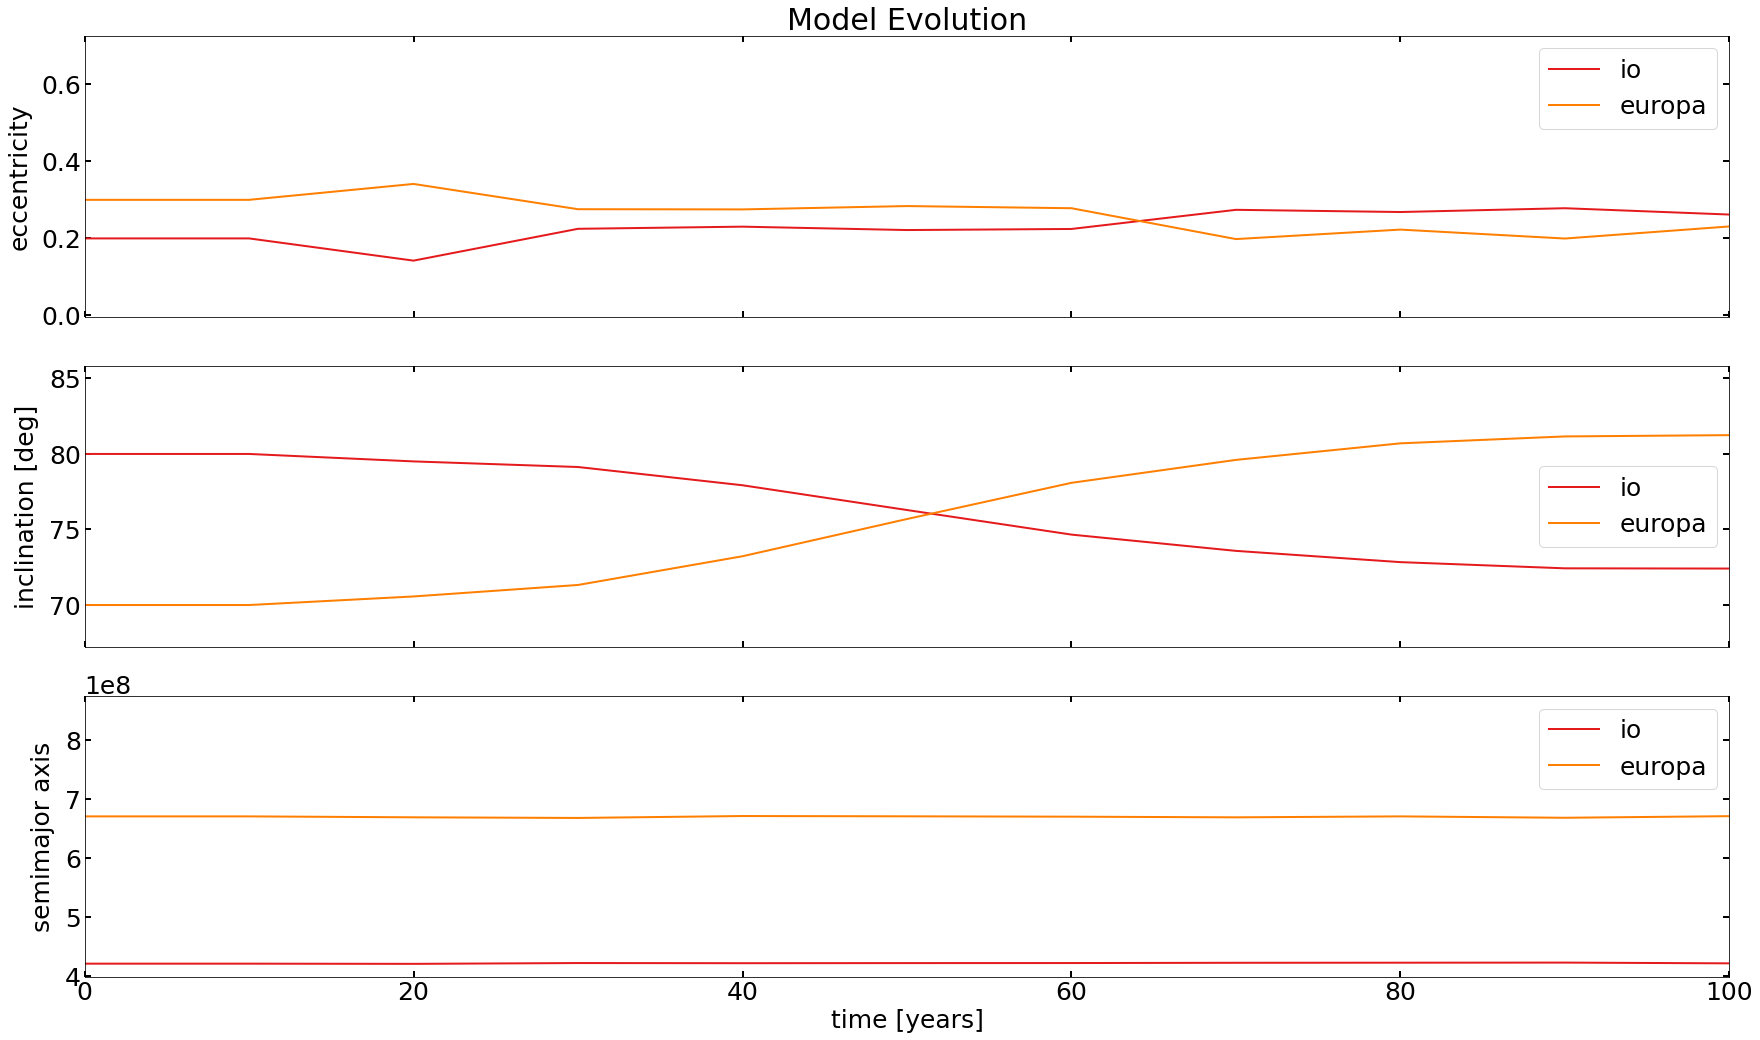

In [27]:
# Plotting evolutionary tracks

def plot_tracks(moons, ecc, inc, sma, time_range, savefig=False, figname='evolved_tracks'):
    
    plt.rcParams.update({'font.size': 25})
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[25, 15], tight_layout=True, sharex=True)
    cb = ['#e41a1c', '#ff7f00', '#999999', '#377eb8']
    
    t = time_range.value_in(units.yr)
    inc = inc.value_in(units.deg)
    ecc = np.array(ecc)
    sma = sma.value_in(units.m)

    for i in range(len(moons)): 
        ax1.plot(t, ecc[i], color=cb[i], label=moons[i], lw=2)   
        ax2.plot(t, inc[i], color=cb[i], label=moons[i], lw=2) 
        ax3.plot(t, sma[i], color=cb[i], label=moons[i], lw=2)   
        
    ax1.set_ylabel('eccentricity', labelpad=10)
    ax2.set_ylabel('inclination [deg]', labelpad=10)
    ax3.set_ylabel('semimajor axis', labelpad=10)
    
    ax1.tick_params(direction='in', length=6, width=2, top=True, right=True)
    ax2.tick_params(direction='in', length=6, width=2, top=True, right=True)    
    ax3.tick_params(direction='in', length=6, width=2, top=True, right=True)
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
  
    ax1.set_title('Model Evolution')
    ax3.set_xlabel('time [years]')

    ax1.set_xlim([0,100])
    ax2.set_xlim([0,100])
    ax3.set_xlim([0,100])

    if savefig:
        plt.savefig(figname+'.png', facecolor='w', bbox_inches='tight')

    plt.show()
    
    
plot_tracks(moons, ecc, inc, sma, time_range)